In [1]:
import torch
import copy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Functions

### For training

In [2]:
cost = nn.MSELoss()

def test(model, x, y):
    model.eval()
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y) 
    return loss.item()

def train(model, x, y):
    model.train()
    # # Uncomment if want to debug
    # model.check_init_norm()
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y)
    loss.backward()
    # # Uncomment if want to debug
    # print('#### Grad norm of SGD:')
    # model.check_layer_grad()
    # raise Exception("Stop here")
    return loss.item()

def train_SVI(model, x, y, small_prev_layer = False):
    model.train()
    # # Uncomment if want to debug
    # print(X.norm())
    # model.check_init_norm()
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y) # MSE was \|x\|^2_2
    #### New lines for SVI #### 
    model.turn_on_off_grad(on = False) 
    #### End #####
    loss.backward() # By this time, model parameters should have no gradients
    # # Uncomment if want to debug
    # print(f'#### Grad norm before SVI')
    # model.check_layer_grad()
    #### New lines for SVI ####
    loss_tilde = 0
    k = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().to(device)
        # This is correct, I have verified it on SVI_old to give the same results
        if small_prev_layer and k < len(model.layers_Xtilde) - 1:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()/Xlplus1.shape[0]
        else:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()
        k += 1
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    # # Uncomment if want to debug
    # print(f'#### Grad norm after SVI')
    # model.check_layer_grad()
    # raise Exception("Stop here")
    model.on_training = False  # To avoid additional .retain_grad()
    #### End #####
    return loss.item()

In [3]:
# Regenerate data and train
def all_together(random_states, SGD = False, small_prev_layer = True, nlayers = 2):
    results_final_dict = {}
    for random_state in random_states:
        ##### Get data
        X, y = make_moons(noise=0.1,
                    n_samples=N,
                    random_state=random_state)
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                            random_state=random_state)
        X_train_t = torch.from_numpy(X_train).to(torch.float32).to(device)
        y_train_t = torch.from_numpy(y_train).to(torch.long).to(device)
        X_test_t = torch.from_numpy(X_test).to(torch.float32).to(device)
        y_test_t = torch.from_numpy(y_test).to(torch.long).to(device)
        train_dataset = TensorDataset(X_train_t, y_train_t)
        test_dataset = TensorDataset(X_test_t, y_test_t)
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=False)
        test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False)
        
        ##### Training
        torch.manual_seed(random_state)
        if SGD:
            if nlayers == 2:
                model = two_moon_net(H).to(device)
            else:
                model = three_moon_net(H).to(device)
        else:
            if nlayers == 2:
                model = two_moon_net_SVI(H).to(device)
            else:
                model = three_moon_net_SVI(H).to(device)
        train_loss_all, train_acc_all = np.zeros(epochs), np.zeros(epochs)
        test_loss_all, test_acc_all = np.zeros(epochs), np.zeros(epochs)
        layer_1_norm_all, layer_2_norm_all = np.zeros(epochs), np.zeros(epochs)
        layer_3_norm_all = np.zeros(epochs)
        dict_ref = copy.deepcopy(model.state_dict())
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momen)
        for t in range(epochs):
            ### Train
            size = len(train_dataloader.dataset)
            train_loss, train_correct = 0, 0
            for X, y in train_dataloader:
                optimizer.zero_grad()
                if SGD:
                    train_loss += train(model, X, y)
                else:
                    train_loss += train_SVI(model, X, y, small_prev_layer = small_prev_layer)
                pred = model(X).argmax(1)
                train_correct += (pred == y).type(torch.float).sum().item()
                optimizer.step()
            train_correct /= size
            train_loss /= size
            train_loss_all[t] = train_loss
            train_acc_all[t] = train_correct
            ### Attach difference in parameter updates
            for name, param in model.named_parameters():
                if '0' in name:
                    layer_1_norm_all[t] += torch.norm(param - dict_ref[name])
                if '1' in name:
                    layer_2_norm_all[t] += torch.norm(param - dict_ref[name])
                else:
                    layer_3_norm_all[t] += torch.norm(param - dict_ref[name])
            ### Test
            size = len(test_dataloader.dataset)
            test_loss, test_correct = 0, 0
            with torch.no_grad():
                model.eval()
                for X, y in test_dataloader:
                    test_loss += test(model, X, y)
                    pred = model(X).argmax(1)
                    test_correct += (pred == y).type(torch.float).sum().item()
            test_correct /= size
            test_loss /= size
            test_loss_all[t] = test_loss
            test_acc_all[t] = test_correct
        name = 'SGD' if SGD else 'SVI'
        suffix = ''
        if SGD == False:
            suffix = 'old' if small_prev_layer else 'new'
        print(f'{name} {suffix}, H={H}, random_state={random_state}')
        print('learning rate=', learning_rate, ', train accuracy=',
                train_acc_all[t] * 100, '%, test accuracy=', test_acc_all[t] * 100, '%')
        print(f'training loss = {train_loss_all[t]:.4f}, test loss = {test_loss_all[t]:.4f}')
        results = {'train_loss': train_loss_all, 
                    'train_acc': train_acc_all, 
                    'test_loss': test_loss_all, 
                    'test_acc': test_acc_all,
                    'layer_1_norm': layer_1_norm_all,
                    'layer_2_norm': layer_2_norm_all,
                    'model': model}
        if nlayers == 3:
            results['layer_3_norm'] = layer_3_norm_all
        results_final_dict[random_state] = results
    return results_final_dict

### For visualization

In [4]:
def get_ave_results(results_final_dict):
    keys = list(results_final_dict.keys())
    num_rep = len(keys)
    epochs = len(list(results_final_dict.values())[0]['train_loss'])
    ave_results, std_results = {}, {}
    std_suffix = '_std'
    for key in results_final_dict[keys[0]]:
        if key == 'model':
            continue
        ave_results[key] = np.zeros((num_rep, epochs))
        std_results[key+std_suffix] = np.zeros((num_rep, epochs))
    for i, random_state in enumerate(keys):
        for key in results_final_dict[random_state].keys():
            if key == 'model':
                continue
            ave_results[key][i] = results_final_dict[random_state][key]
            std_results[key+std_suffix][i] = results_final_dict[random_state][key]
    for key in ave_results.keys():
        ave_results[key] = np.mean(ave_results[key], axis = 0)
        std_results[key+std_suffix] = np.std(std_results[key+std_suffix], axis = 0)  
    final_dict = {}
    for key in ave_results.keys():
        final_dict[key] = ave_results[key]
        final_dict[key+std_suffix] = std_results[key+std_suffix] 
    return final_dict

In [5]:
def plot_on_axes(train_mean, train_std, test_mean, test_std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(train_mean, color = color, label = label + ' train')
    ax.plot(test_mean, color = color, linestyle = '--', label = label + ' test')
    ax.fill_between(range(len(train_mean)), train_mean - train_std, train_mean + train_std, alpha = 0.2, color = color)
    ax.fill_between(range(len(test_mean)), test_mean - test_std, test_mean + test_std, alpha = 0.2, color = color)
    ax.legend()

def plot_on_axes_sub(mean, std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(mean, color = color, label = label + ' train')
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha = 0.2, color = color)
    ax.legend()

## Two layer

In [6]:
class two_moon_net(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(nn.Linear(2, H))
        self.convs.append(nn.Linear(H, 2))

    def forward(self, x):
        x = F.relu(self.convs[0](x)) 
        self.layer1_x = Variable(x, requires_grad=True)
        layer2_x = self.convs[1](self.layer1_x) 
        return F.softmax(layer2_x, dim=1)


class two_moon_net_SVI(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(nn.Linear(2, H))
        self.convs.append(nn.Linear(H, 2))

        #### New lines for SVI ####
        # If any layer true, then it needs to use SVI
        self.layers_with_SVI = [True for i in range(len(self.convs))]
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on
    #### End #####

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            #### New lines for SVI ####
            # This is added b/c o/w the gradient backprop w.r.t. new loss also gets to earlier layers (undesirable)
            if self.layers_with_SVI[i] and self.on_training:
                x_tmp = x.detach().clone().to(device)
                self.layers_Xtilde.append(conv(x_tmp))
            #### End #####
            x = conv(x)
            if i < len(self.convs) - 1:
                x = F.relu(x)
            else:
                x = F.softmax(x, dim=1)
            #### New lines for SVI ####
            if self.layers_with_SVI[i] and self.on_training:
                x.retain_grad()  # To get the gradient with respect to output
                self.layers_grad.append(x)
            #### End #####
        return x
    
def check_layer_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(name, param.grad.norm())

def check_init_norm(model):
    print("#### Initial norm of parameters: ")
    for name, param in model.named_parameters():
        print(name, param.norm())

### 32 hidden nodes

In [7]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
random_states = [1111]
H = 32
nlayers = 2
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
learning_rate = 0.001
momen = 0.9
epochs = 100
epochs = 3000

In [8]:
# SGD
# Should reach 98/99
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

SGD , H=32, random_state=1111
learning rate= 0.001 , train accuracy= 92.80000000000001 %, test accuracy= 91.60000000000001 %
training loss = 0.0006, test loss = 0.0006


In [9]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

SVI old, H=32, random_state=1111
learning rate= 0.001 , train accuracy= 94.6 %, test accuracy= 93.8 %
training loss = 0.0004, test loss = 0.0005


In [10]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

SVI new, H=32, random_state=1111
learning rate= 0.001 , train accuracy= 94.39999999999999 %, test accuracy= 93.4 %
training loss = 0.0005, test loss = 0.0005


H = 32, by epoch 3000 out of 3000 epochs
####################
SGD train loss mean: 0.0005710712373256684 +/- 0.0
SVI_old train loss mean: 0.0004332672208547592 +/- 0.0
SVI train loss mean: 0.0004546369612216949 +/- 0.0
####################
SGD test loss mean: 0.0006084051653742791 +/- 0.0
SVI_old test loss mean: 0.0004571054577827454 +/- 0.0
SVI test loss mean: 0.0004917376600205898 +/- 0.0
####################
SGD train error mean: 0.07199999999999995 +/- 0.0
SVI_old train error mean: 0.05400000000000005 +/- 0.0
SVI train error mean: 0.05600000000000005 +/- 0.0
####################
SGD test error mean: 0.08399999999999996 +/- 0.0
SVI_old test error mean: 0.062000000000000055 +/- 0.0
SVI test error mean: 0.06599999999999995 +/- 0.0


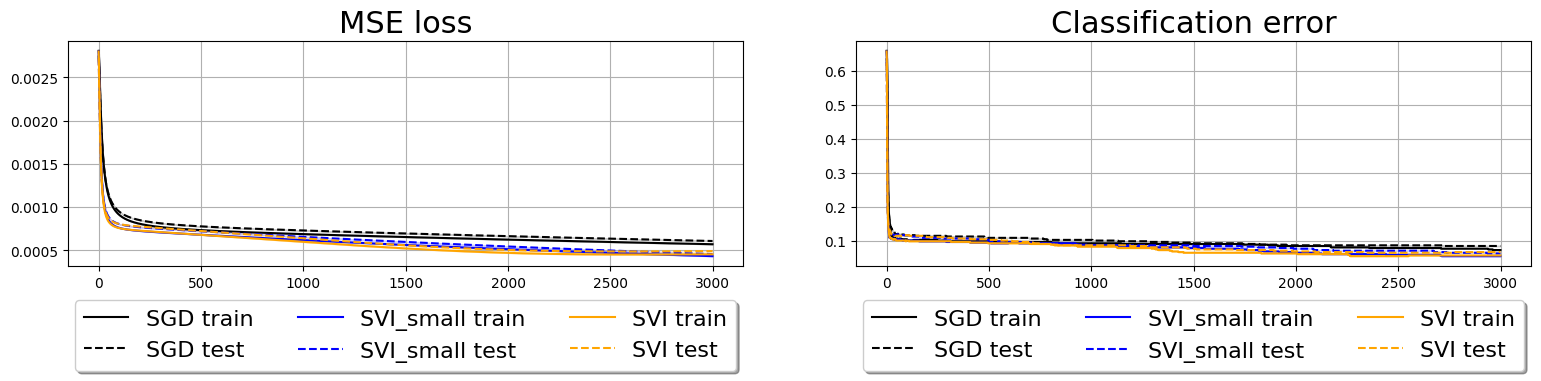

In [11]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = epochs
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

### 64 hidden nodes

In [12]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
random_states = [1111]
H = 64
nlayers = 2
N = 1000
batch_size = int(N/10)
learning_rate = 0.15
learning_rate = 0.001
momen = 0.9
epochs = 100
epochs = 3000

In [13]:
# SGD
results_final_dict_SGD = all_together(random_states, SGD = True, nlayers = nlayers)

In [ ]:
# SVI old small scale
results_final_dict_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True, nlayers = nlayers)

In [ ]:
# SVI new original scale
results_final_dict_SVI_new = all_together(random_states, SGD = False,
                                          small_prev_layer = False, nlayers = nlayers)

In [ ]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 100
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI_old train loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old test loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI_old train error mean: {1-ave_results_SVI_old["train_acc"][stop-1]} +/- {ave_results_SVI_old["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI_new["train_acc"][stop-1]} +/- {ave_results_SVI_new["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI_old test error mean: {1-ave_results_SVI_old["test_acc"][stop-1]} +/- {ave_results_SVI_old["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI_new["test_acc"][stop-1]} +/- {ave_results_SVI_new["test_acc_std"][stop-1]}')

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()